In [1]:
%matplotlib inline
from tqdm import tqdm
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from itertools import islice

from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from model import VQTrEstimator

In [2]:
dataset = get_dataset("traffic")

In [3]:
estimator = VQTrEstimator(
    freq=dataset.metadata.freq,
    prediction_length=dataset.metadata.prediction_length,
    context_length=dataset.metadata.prediction_length*20,
    codebook_size=10,
    dim_head=8,
    nhead=2,
    depth=1,
    num_encoder_layers=2,
    num_decoder_layers=2,
    dim_feedforward=16,
    activation="gelu",

    num_feat_static_cat=1,
    cardinality=[int(dataset.metadata.feat_static_cat[0].cardinality)],
    embedding_dimension=[3],
    
    scaling=True,
  
    batch_size=256,
    num_batches_per_epoch=300,
    trainer_kwargs=dict(max_epochs=10,),
)

In [4]:
predictor = estimator.train(
    training_data=dataset.train,
    shuffle_buffer_length=512,
    cache_data=True,
)

/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:197: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
Authorization required, but no authorization protocol specified

Authorization required, but no authorization protocol specified

Authorization required, but no authorization protocol specified

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:71: PossibleUserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn(
You are using a CUDA device ('NVIDIA GeForce RTX 3090 Ti') that has Tensor Cores. To properly utilize them, you sh

Training: 0it [00:00, ?it/s]

Epoch 0, global step 300: 'train_loss' reached 687630909440.00000 (best 687630909440.00000), saving model to '/mnt/scratch/kashif/vq-tr/lightning_logs/version_111/checkpoints/epoch=0-step=300.ckpt' as top 1
Epoch 1, global step 600: 'train_loss' reached -3.44755 (best -3.44755), saving model to '/mnt/scratch/kashif/vq-tr/lightning_logs/version_111/checkpoints/epoch=1-step=600.ckpt' as top 1
Epoch 2, global step 900: 'train_loss' reached -3.58181 (best -3.58181), saving model to '/mnt/scratch/kashif/vq-tr/lightning_logs/version_111/checkpoints/epoch=2-step=900.ckpt' as top 1
Epoch 3, global step 1200: 'train_loss' was not in top 1
Epoch 4, global step 1500: 'train_loss' was not in top 1
/home/kashif/.env/pytorch/lib/python3.10/site-packages/pytorch_lightning/trainer/call.py:53: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [6]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=dataset.test,
    predictor=predictor
)

In [9]:
forecasts = [f for f in tqdm(forecast_it)]


0it [00:00, ?it/s]
1it [00:06,  6.23s/it]
257it [00:12, 24.67it/s]
513it [00:18, 32.75it/s]
769it [00:24, 36.59it/s]
1025it [00:30, 38.70it/s]
1281it [00:36, 39.99it/s]
1537it [00:42, 40.78it/s]
1793it [00:48, 41.28it/s]
2049it [00:54, 41.62it/s]
2305it [01:00, 41.85it/s]
2561it [01:06, 42.01it/s]
2817it [01:12, 42.10it/s]
3073it [01:18, 42.18it/s]
3329it [01:24, 42.23it/s]
3585it [01:30, 42.25it/s]
3841it [01:36, 42.27it/s]
4097it [01:42, 42.28it/s]
4353it [01:48, 42.28it/s]
4609it [01:54, 42.27it/s]
4865it [02:01, 42.29it/s]
5121it [02:07, 42.29it/s]
5377it [02:13, 42.26it/s]
5633it [02:19, 42.25it/s]
6034it [02:22, 42.28it/s]


In [10]:
tss = list(ts_it)

In [11]:
evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(dataset.test))


Running evaluation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6034/6034 [00:00<00:00, 79722.39it/s]
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/gluon-ts-PR/src/gluonts/evaluation/_base.py:425: RuntimeWarning: divide by zero encountered in float_scalars
  metrics["ND"] = cast(float, metrics["abs_error"]) / cast(
/home/kashif/.env/pytorch/l

In [12]:
agg_metrics

{'MSE': 0.0008801566423376631,
 'abs_error': 1542.5934617277235,
 'abs_target_sum': 8672.5710073933,
 'abs_target_mean': 0.0598868288545002,
 'seasonal_error': 0.015220711169889631,
 'MASE': 0.6860714337394219,
 'MAPE': 0.2668257973748838,
 'sMAPE': 0.18135226298868162,
 'MSIS': 7.905145420819292,
 'num_masked_target_values': 0.0,
 'QuantileLoss[0.1]': 779.8536916050384,
 'Coverage[0.1]': 0.04025107722903547,
 'QuantileLoss[0.2]': 1124.1057388721097,
 'Coverage[0.2]': 0.0876422494751961,
 'QuantileLoss[0.3]': 1344.2174098755113,
 'Coverage[0.3]': 0.15323583029499502,
 'QuantileLoss[0.4]': 1480.3774233545037,
 'Coverage[0.4]': 0.23989752513534413,
 'QuantileLoss[0.5]': 1542.5934624473487,
 'Coverage[0.5]': 0.3441884874599491,
 'QuantileLoss[0.6]': 1548.401538211428,
 'Coverage[0.6]': 0.4533269804441498,
 'QuantileLoss[0.7]': 1457.689478189037,
 'Coverage[0.7]': 0.5889197326262291,
 'QuantileLoss[0.8]': 1271.685623006249,
 'Coverage[0.8]': 0.7316318638824438,
 'QuantileLoss[0.9]': 956.54

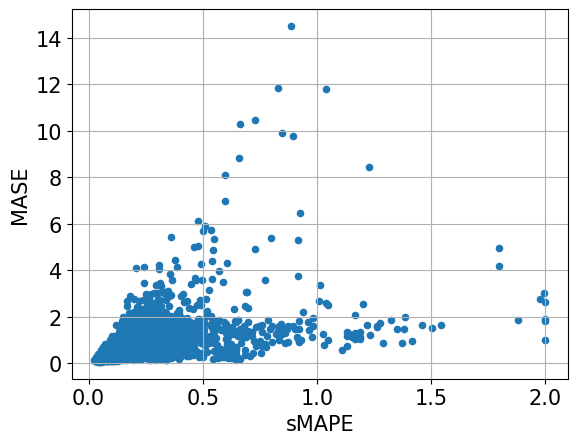

In [14]:
ts_metrics.plot(x='sMAPE', y='MASE', kind='scatter')
plt.grid(which="both")
plt.show()

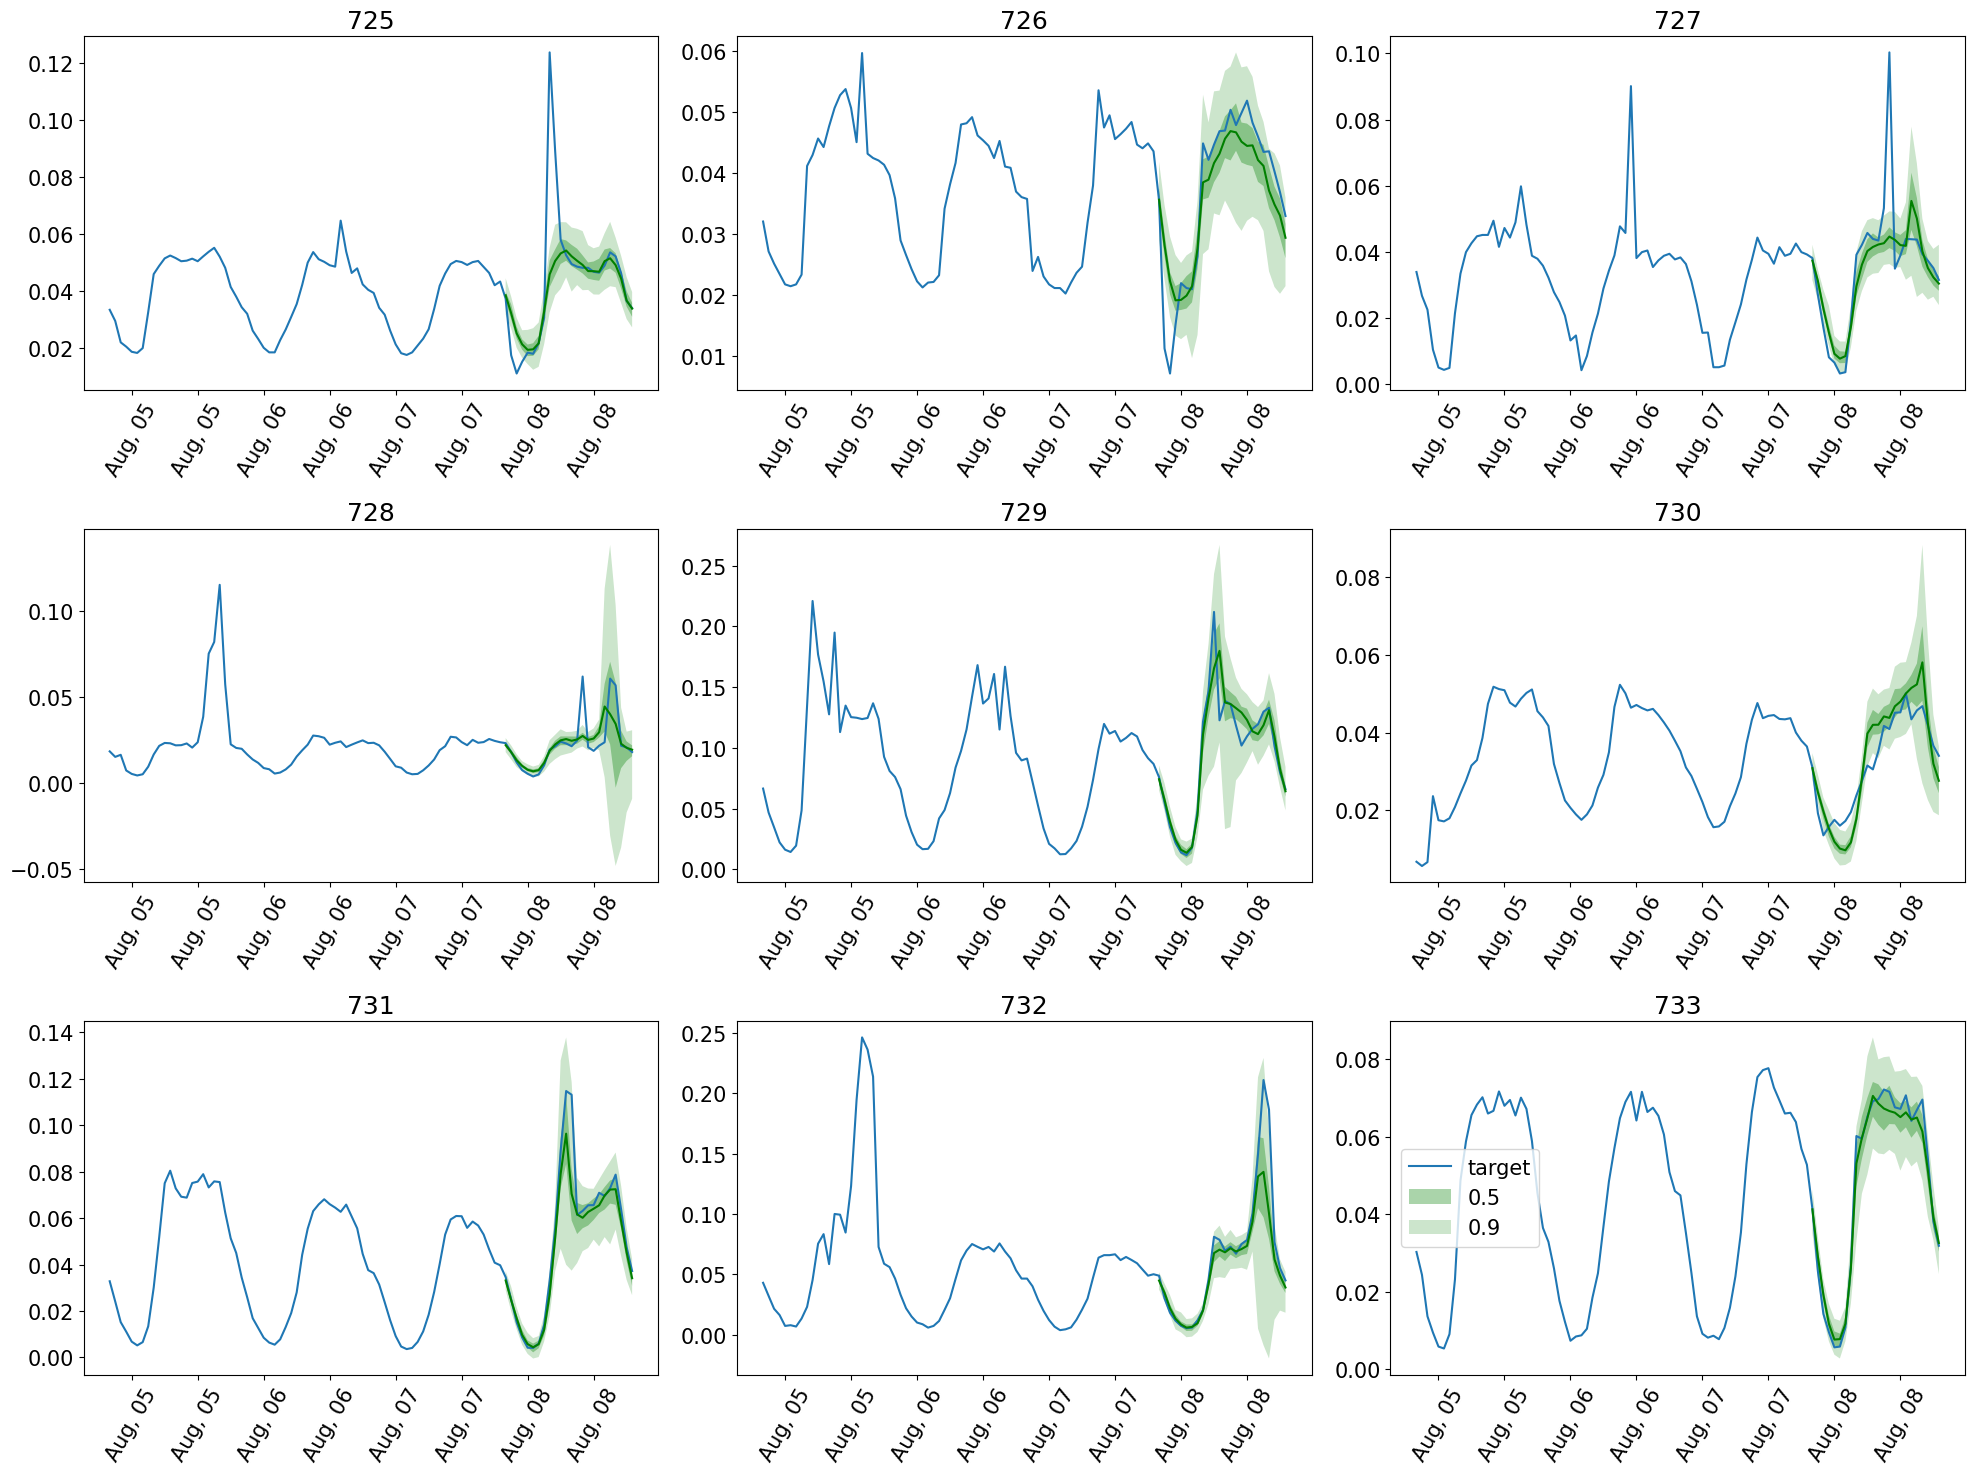

In [13]:
plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter('%b, %d')
plt.rcParams.update({'font.size': 15})

for idx, (forecast, ts) in islice(enumerate(zip(forecasts, tss)), 725, 725+9):
    ax = plt.subplot(3, 3, idx+1-725)

    plt.plot(ts[-4 * dataset.metadata.prediction_length:].to_timestamp(), label="target")
    forecast.plot(color='g', show_label=True)
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    plt.title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()